# Meta-Learning Time Series Forecasting with Recency Bias

In [15]:
import sys
import os

# Go up one level to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [16]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Import custom dataset
from util.config_util import ShapeConfig, dotdict
from util.train import gaussian_nll_loss, get_opt_lr_schedule, validate_model
from data.variable_meta_dataset import VariableMetaDataset
from models.LinearPFN import LinearPFN

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Configuration for synthetic data generation
shape_config = ShapeConfig(
    n_context=2,
    n_sequence=12_000,  # Length of synthetic series
    n_features=1,    # Univariate series
    n_heldout=1,
    n_prompt=1
)

# Hyperprior parameters for realistic time series
seasonality_base = 3.0
w, m, a = seasonality_base*1, seasonality_base*2, seasonality_base*4

hyperprior_params = dotdict({
    # Seasonality parameters
    'a_min': -a, 'a_max': a, 'a_fixed_variance': 0.15,
    'm_min': -m, 'm_max': m, 'm_fixed_variance': 0.15,
    'w_min': -w, 'w_max': w, 'w_fixed_variance': 0.15,
    
    # Trend parameters
    'trend_lin_min': -0.015, 'trend_lin_max': 0.015, 'trend_lin_fixed_variance': 0.005,
    'trend_exp_min': 1 - 0.005, 'trend_exp_max': 1 + 0.005, 'trend_exp_fixed_variance': 0.001,
    'trend_exp_multiplier': 400,
    
    # Noise and resolution
    'noise_k_min': 0.5, 'noise_k_max': 3.5,
    'resolution_min': 0.1, 'resolution_max': 1.2, 'resolution_multiplier': 50,
    
    # Other parameters
    'harmonics_min': 2, 'harmonics_max': 8,
    'discreteness_min': 1, 'discreteness_max': 6,
    'bias_zi_min': 0.8, 'bias_zi_max': 3.0,
    'amplitude_min': 0.5, 'amplitude_max': 4.0,
    'non_negative_prob': 0.2,
    'offset_lin_min': -1.0, 'offset_lin_max': 1.2,
    'offset_exp_min': -1.5, 'offset_exp_max': 2.0,
    'f_zi_min': 0.0, 'f_zi_max': 0.6, 'f_zi_fixed_variance': 0.3
})

In [18]:
dataset = VariableMetaDataset(
    shape_config=shape_config,
    hyperprior_params=hyperprior_params,
    L=96, H=96,
    C_range=(32, 1536),
    Q_range=(1, 16),
    device=device,
    sample_log_uniform=True
)

# Test variable sampling
print("\nTesting variable C,Q sampling:")
for i in range(5):
    task = dataset.create_meta_task()
    C_actual = task['ctx_x'].shape[0]
    Q_actual = task['qry_x'].shape[0]
    print(f"  Sample {i+1}: C={C_actual}, Q={Q_actual}")
    print(f"    Series stats: μ={task['stats']['mu']:.3f}, σ={task['stats']['sigma']:.3f}")

Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x728a1f9df820> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: (32, 1536) (log-uniform)
  Q range: (1, 16)
  Max patches needed: C=1536, Q=16

Testing variable C,Q sampling:
  Sample 1: C=498, Q=9
    Series stats: μ=-3.133, σ=31.309
  Sample 2: C=1240, Q=16
    Series stats: μ=100.566, σ=300.895
  Sample 3: C=113, Q=16
    Series stats: μ=-232.917, σ=752.303
  Sample 4: C=920, Q=2
    Series stats: μ=-499.777, σ=3000.689
  Sample 5: C=60, Q=13
    Series stats: μ=12.694, σ=183.243


In [19]:
# ===== TRAINING: 500K TASKS =====

model = LinearPFN(
    L=dataset.L,
    H=dataset.H,
    d=768,      # embedding size
    L_blk=16,   # number of transformer blocks
    n_heads=12, # number of attention heads
    d_ff=3072,  # feedforward size
    dropout=0.1
).to(device)

model_params = sum(p.numel() for p in model.parameters())
print(f"Model: {model_params:,} parameters")

# training configuration
train_config = {
    'total_tasks': 1_000_000,          # 500K tasks
    'tasks_per_epoch': 5_000,        # 5K tasks per epoch  
    'validate_every': 4,            # Validate every 10 epochs
    'save_every': 20,                # Save every 20 epochs
    'log_every': 500,                # Log every 500 tasks
    'n_val_tasks': 1000,              # Validation tasks
    'early_stopping_patience': 10,   # Patience for 500K training
    'warmup_tasks': 100_000,           # LR warmup period
}

n_epochs = train_config['total_tasks'] // train_config['tasks_per_epoch']

print(f"\nTraining Plan:")
print(f"  Total meta-tasks: {train_config['total_tasks']:,}")
print(f"  Tasks per epoch: {train_config['tasks_per_epoch']:,}")
print(f"  Total epochs: {n_epochs}")
print(f"  Variable C: {dataset.C_range} (log-uniform)")
print(f"  Variable Q: {dataset.Q_range}")

optimizer, scheduler = get_opt_lr_schedule(model, train_config)

print("500K task training setup ready!")
print("Using LaTPFN prior")
print("Variable C,Q sampling")

Model: 113,776,236 parameters

Training Plan:
  Total meta-tasks: 1,000,000
  Tasks per epoch: 5,000
  Total epochs: 200
  Variable C: (32, 1536) (log-uniform)
  Variable Q: (1, 16)
500K task training setup ready!
Using LaTPFN prior
Variable C,Q sampling


In [20]:
import time
from collections import defaultdict

print("STARTING 500K TASK TRAINING")

# Training tracking
history = defaultdict(list)
best_val_loss = float('inf')
patience_counter = 0
start_time = time.time()
global_task_count = 0

criterion = nn.MSELoss()

# Initial validation
print("Running initial validation...")
val_metrics = validate_model(model, dataset, device, train_config['n_val_tasks'], use_time=True)
print(f"Initial validation - Loss: {val_metrics['loss']:.4f}, Corr: {val_metrics['correlation']:.3f}")
print(f"Initial C range: {val_metrics['C_range']}, Q range: {val_metrics['Q_range']}")

# 500K training loop
model.train()
ckpt_dir = f'../ckpts/t_{dataset.L}_{dataset.H}'
os.makedirs(ckpt_dir, exist_ok=True)

for epoch in range(n_epochs):
    epoch_start = time.time()
    epoch_losses = []
    epoch_C_sizes = []
    epoch_Q_sizes = []
    
    for task_idx in range(train_config['tasks_per_epoch']):
        optimizer.zero_grad()
        
        # Create meta-task with variable C,Q
        task = dataset.create_meta_task()
        
        # Track sizes
        C_actual = task['ctx_x'].shape[0]
        Q_actual = task['qry_x'].shape[0]
        epoch_C_sizes.append(C_actual)
        epoch_Q_sizes.append(Q_actual)
        
        ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)
        ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)
        qry_x = task['qry_x'].unsqueeze(0).float().to(device)
        qry_z = task['qry_z'].unsqueeze(0).float().to(device)

        t_ctx = torch.tensor(task['endpoints']['ctx'], dtype=torch.long).unsqueeze(0).to(device)  # [1,C]
        t_qry = torch.tensor(task['endpoints']['qry'], dtype=torch.long).unsqueeze(0).to(device)  # [1,Q]


        # Forward pass
        pred = model(ctx_x, ctx_z, qry_x, t_ctx, t_qry)
        loss = criterion(pred, qry_z)
        # mu, log_sigma2 = model(ctx_x, ctx_z, qry_x)
        # loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        epoch_losses.append(loss.item())
        global_task_count += 1
        
        # Logging
        if task_idx % train_config['log_every'] == 0:
            current_lr = optimizer.param_groups[0]['lr']
            recent_C = epoch_C_sizes[-min(len(epoch_C_sizes), train_config['log_every']):]
            recent_Q = epoch_Q_sizes[-min(len(epoch_Q_sizes), train_config['log_every']):]
            avg_C = np.mean(recent_C)
            avg_Q = np.mean(recent_Q)
            elapsed_hours = (time.time() - start_time) / 3600
            
            print(f"Epoch {epoch+1:3d}/{n_epochs}, Task {global_task_count:6,}/{train_config['total_tasks']:,}: "
                  f"Loss={loss.item():.4f}, LR={current_lr:.2e}, "
                  f"C̄={avg_C:.1f}, Q̄={avg_Q:.1f}, t={elapsed_hours:.2f}h")
    
    # Epoch statistics
    avg_train_loss = np.mean(epoch_losses)
    avg_C_epoch = np.mean(epoch_C_sizes)
    avg_Q_epoch = np.mean(epoch_Q_sizes)
    
    history['loss'].append(avg_train_loss)
    history['avg_C'].append(avg_C_epoch)
    history['avg_Q'].append(avg_Q_epoch)
    history['epoch'].append(epoch + 1)
    
    epoch_time = time.time() - epoch_start
    
    # Validation
    if (epoch + 1) % train_config['validate_every'] == 0:
        print(f"\nValidation after epoch {epoch + 1}...")
        val_metrics = validate_model(model, dataset, device, train_config['n_val_tasks'], use_time=True)
        
        history['val_loss'].append(val_metrics['loss'])
        history['val_correlation'].append(val_metrics['correlation'])
        history['val_epoch'].append(epoch + 1)
        
        tasks_per_hour = global_task_count / ((time.time() - start_time) / 3600)
        
        print(f"Epoch {epoch+1:3d} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f} (C̄={avg_C_epoch:.1f}, Q̄={avg_Q_epoch:.1f})")
        print(f"  Val Loss: {val_metrics['loss']:.4f} ± {val_metrics['loss_std']:.4f}")
        print(f"  Val Corr: {val_metrics['correlation']:.3f} ± {val_metrics['correlation_std']:.3f}")
        print(f"  Val C range: {val_metrics['C_range']}, Q range: {val_metrics['Q_range']}")
        print(f"  Speed: {tasks_per_hour:,.0f} tasks/hour, Tasks: {global_task_count:,}")
        
        # Early stopping
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_correlation': val_metrics['correlation'],
                'epoch': epoch + 1,
                'global_tasks': global_task_count,
                'config': train_config,
                'dataset_config': {
                    'L': dataset.L, 'H': dataset.H,
                    'C_range': dataset.C_range, 'Q_range': dataset.Q_range
                }
            }, f'{ckpt_dir}/best_model.pt')
            print(f"  Best model saved! (tasks: {global_task_count:,})")
        else:
            patience_counter += 1
            
        if patience_counter >= train_config['early_stopping_patience']:
            print(f"\nEarly stopping after {patience_counter} epochs without improvement")
            break
    
    # Regular checkpoints
    if (epoch + 1) % train_config['save_every'] == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,
            'global_tasks': global_task_count,
            'history': dict(history)
        }, f'{ckpt_dir}/model_epoch_{epoch+1}.pt')

total_time = time.time() - start_time
tasks_per_hour = global_task_count / (total_time / 3600)

print(f"\n 500K TRAINING COMPLETE! ")
print(f"Total time: {total_time/3600:.2f} hours")
print(f"Total tasks trained: {global_task_count:,}")
print(f"Average speed: {tasks_per_hour:,.0f} tasks/hour")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Model saved: {ckpt_dir}/best_model.pt")

STARTING 500K TASK TRAINING
Running initial validation...
Initial validation - Loss: 18.6939, Corr: 0.001
Initial C range: 32-1524, Q range: 1-16
Epoch   1/200, Task      1/1,000,000: Loss=24.1804, LR=1.00e-09, C̄=80.0, Q̄=1.0, t=0.01h
Epoch   1/200, Task    501/1,000,000: Loss=15.7416, LR=5.01e-07, C̄=384.9, Q̄=8.7, t=0.03h
Epoch   1/200, Task  1,001/1,000,000: Loss=16.7301, LR=1.00e-06, C̄=391.3, Q̄=8.9, t=0.04h
Epoch   1/200, Task  1,501/1,000,000: Loss=7.8678, LR=1.50e-06, C̄=388.0, Q̄=8.9, t=0.06h
Epoch   1/200, Task  2,001/1,000,000: Loss=6.8062, LR=2.00e-06, C̄=376.8, Q̄=8.5, t=0.07h
Epoch   1/200, Task  2,501/1,000,000: Loss=1.9157, LR=2.50e-06, C̄=395.5, Q̄=8.5, t=0.08h
Epoch   1/200, Task  3,001/1,000,000: Loss=7.0976, LR=3.00e-06, C̄=383.6, Q̄=8.9, t=0.10h
Epoch   1/200, Task  3,501/1,000,000: Loss=5.4974, LR=3.50e-06, C̄=396.9, Q̄=8.5, t=0.11h
Epoch   1/200, Task  4,001/1,000,000: Loss=2.6427, LR=4.00e-06, C̄=373.8, Q̄=8.6, t=0.13h
Epoch   1/200, Task  4,501/1,000,000: Loss

Generating test examples with variable C,Q sizes...
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7faf60062e30> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 50 (log-uniform)
  Q range: 1
  Max patches needed: C=50, Q=1
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7faf60376830> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 128 (log-uniform)
  Q range: 4
  Max patches needed: C=128, Q=4
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7fafc40c5540> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 176 (log-uniform)
  Q range: 2
  Max patches needed: C=176, Q=2
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7fafc40e7c10> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 250 (log-uniform)
  Q range: 1
  Max patches needed: C=250, Q=1


/tmp/ipykernel_1705471/2669663893.py:201: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


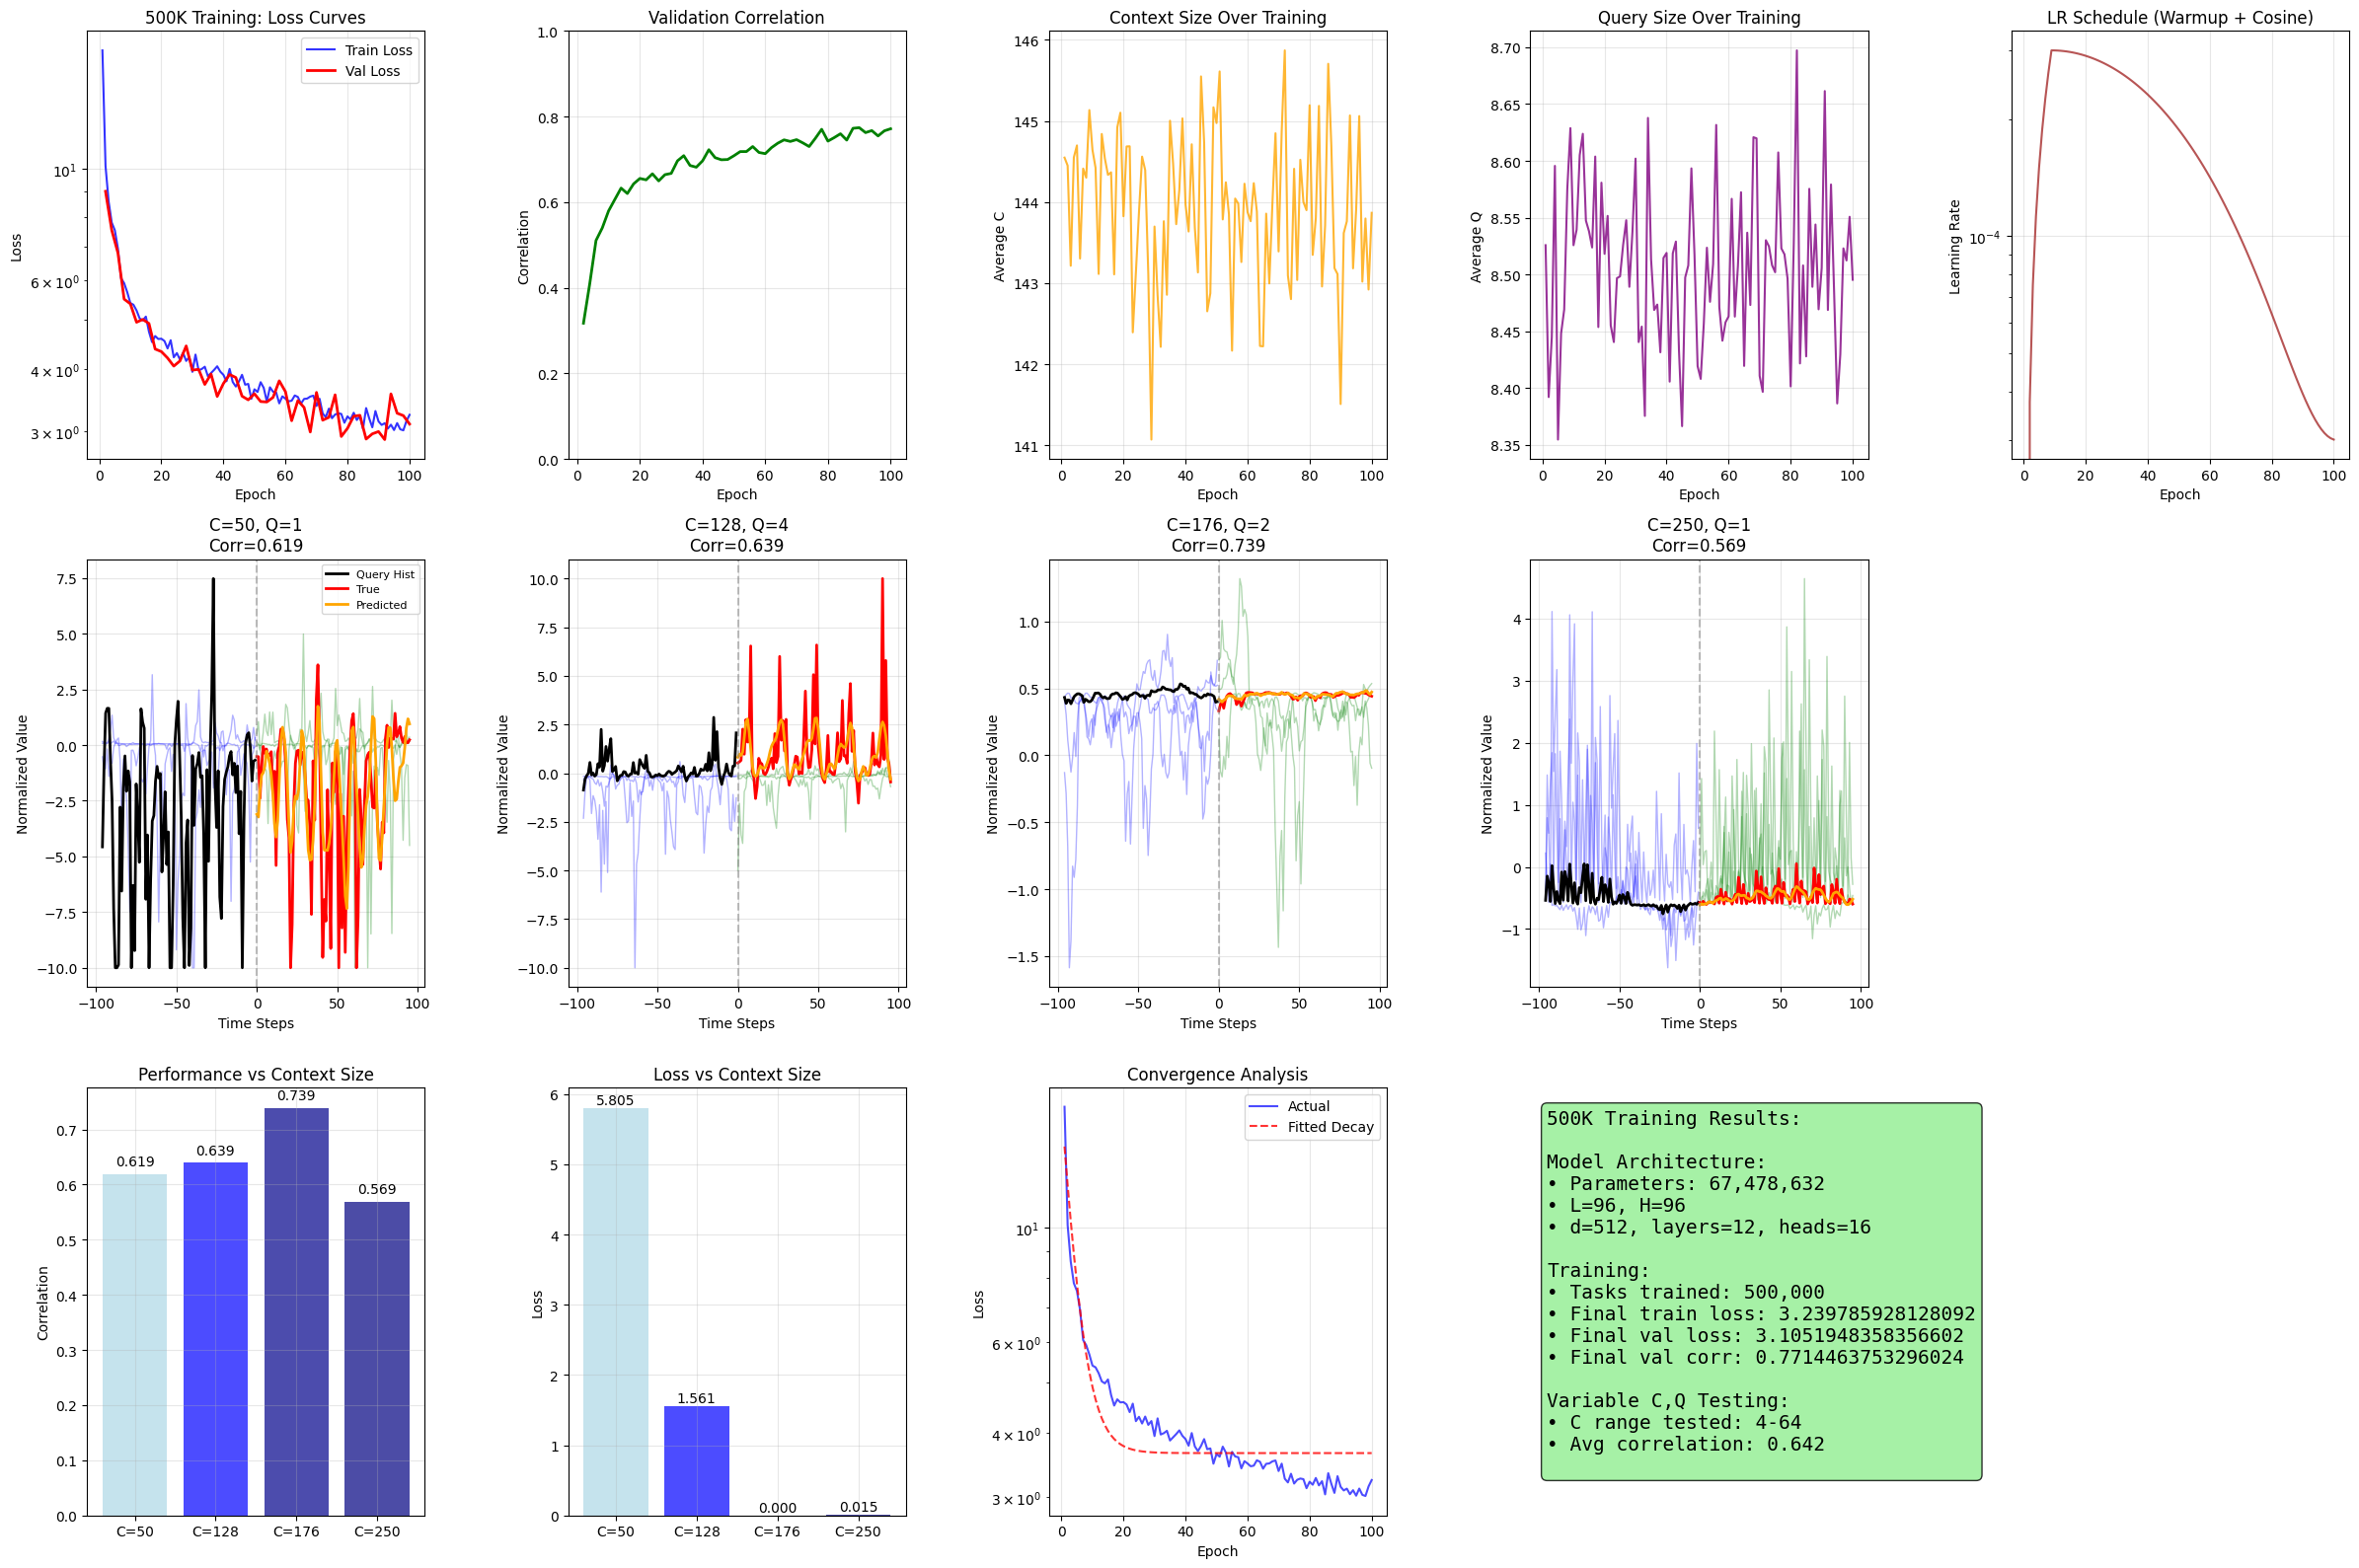


500K TRAINING ANALYSIS
Model: 67,478,632 parameters
Tasks trained: 500,000
Training speed: 103,026 tasks/hour
Best validation loss: 2.8923

 VARIABLE C,Q TEST RESULTS:
  C=50, Q=1: Correlation=0.619, Loss=5.8051
  C=128, Q=4: Correlation=0.639, Loss=1.5613
  C=176, Q=2: Correlation=0.739, Loss=0.0003
  C=250, Q=1: Correlation=0.569, Loss=0.0154


In [ ]:
# ===== 500K TRAINING VISUALIZATION & ANALYSIS =====
plt.figure(figsize=(24, 16))

# Training curves
plt.subplot(3, 5, 1)
if history['loss']:
    plt.plot(history['epoch'], history['loss'], 'b-', label='Train Loss', alpha=0.8)
if 'val_loss' in history and history['val_loss']:
    plt.plot(history['val_epoch'], history['val_loss'], 'r-', label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('500K Training: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Validation correlation over time
plt.subplot(3, 5, 2)
if 'val_correlation' in history and history['val_correlation']:
    plt.plot(history['val_epoch'], history['val_correlation'], 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Correlation')
    plt.title('Validation Correlation')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

# Context size distribution over training
plt.subplot(3, 5, 3)
if history['avg_C']:
    plt.plot(history['epoch'], history['avg_C'], 'orange', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Average C')
    plt.title('Context Size Over Training')
    plt.grid(True, alpha=0.3)

# Query size distribution over training
plt.subplot(3, 5, 4)
if history['avg_Q']:
    plt.plot(history['epoch'], history['avg_Q'], 'purple', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Average Q')
    plt.title('Query Size Over Training')
    plt.grid(True, alpha=0.3)

# Learning rate schedule
plt.subplot(3, 5, 5)
if history['epoch']:
    # Approximate LR schedule
    total_steps = len(history['loss']) * train_config['tasks_per_epoch']
    lr_steps = np.arange(total_steps)
    lrs = []
    for step in lr_steps:
        if step < train_config['warmup_tasks']:
            lr = 3e-4 * step / train_config['warmup_tasks']
        else:
            progress = (step - train_config['warmup_tasks']) / (train_config['total_tasks'] - train_config['warmup_tasks'])
            lr = 3e-4 * (0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress)))
        lrs.append(lr)
    
    epoch_lrs = [lrs[i * train_config['tasks_per_epoch']] for i in range(len(history['epoch']))]
    plt.plot(history['epoch'], epoch_lrs, 'brown', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('LR Schedule (Warmup + Cosine)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

print("Generating test examples with variable C,Q sizes...")
model.eval()

# Generate test examples with different C,Q combinations
test_combinations = [
    (50, 1),    # Small context, single query
    (128, 4),   # Medium context, multiple queries
    (176, 2),   # Large context, few queries
    (250, 1),   # Very large context, single query (extrapolation)
]

test_results = []
for i, (C_test, Q_test) in enumerate(test_combinations):
    # Create custom dataset for this C,Q
    dataset_test = VariableMetaDataset(
        shape_config=shape_config,
        hyperprior_params=hyperprior_params,
        L=dataset.L, H=dataset.H,
        C_range=C_test, Q_range=Q_test,  # Fixed sizes
        device=device)
    
    task = dataset_test.create_meta_task()
    
    ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)
    ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)
    qry_x = task['qry_x'].unsqueeze(0).float().to(device)
    qry_z = task['qry_z'].unsqueeze(0).float().to(device)

    t_ctx = torch.tensor(task['endpoints']['ctx'], dtype=torch.long).unsqueeze(0).to(device)  # [1,C]
    t_qry = torch.tensor(task['endpoints']['qry'], dtype=torch.long).unsqueeze(0).to(device)  # [1,Q]

    
    with torch.no_grad():
        # mu, log_sigma2 = model(ctx_x, ctx_z, qry_x)
        # sigma = torch.exp(0.5 * log_sigma2)
        mu = model(ctx_x, ctx_z, qry_x, t_ctx, t_qry)
        loss = criterion(mu, qry_z)
        # loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
    
    # Calculate correlation
    mu_flat = mu.flatten().cpu()
    qry_z_flat = qry_z.flatten().cpu()
    corr = torch.corrcoef(torch.stack([mu_flat, qry_z_flat]))[0, 1]
    
    test_results.append({
        'C': C_test, 'Q': Q_test, 'task': task,
        # 'mu': mu, 'sigma': sigma, 'qry_z': qry_z,
        'mu': mu, 'qry_z': qry_z,
        'loss': loss.item(), 'correlation': corr.item() if not torch.isnan(corr) else 0
    })
    
    # Visualize this test case
    plt.subplot(3, 5, 6 + i)
    
    hist_points = np.arange(-dataset.L, 0)
    fore_points = np.arange(0, dataset.H)
    
    # Show a few context examples
    ctx_x_cpu = task['ctx_x'].cpu()
    ctx_z_cpu = task['ctx_z'].cpu()
    n_show = min(3, C_test)
    for j in range(n_show):
        alpha = 0.3 if n_show > 1 else 0.6
        plt.plot(hist_points, ctx_x_cpu[j], 'b-', alpha=alpha, linewidth=1)
        plt.plot(fore_points, ctx_z_cpu[j], 'g-', alpha=alpha, linewidth=1)
    
    # Show query (first one if multiple)
    qry_idx = 0
    qry_x_cpu = task['qry_x'][qry_idx].cpu()
    qry_z_true = task['qry_z'][qry_idx].cpu()
    qry_pred = mu[0, qry_idx].cpu()
    # qry_std = sigma[0, qry_idx].cpu()
    
    plt.plot(hist_points, qry_x_cpu, 'k-', linewidth=2, label='Query Hist')
    plt.plot(fore_points, qry_z_true, 'r-', linewidth=2, label='True')
    plt.plot(fore_points, qry_pred, 'orange', linewidth=2, label='Predicted')
    # plt.fill_between(fore_points, qry_pred - 2*qry_std, qry_pred + 2*qry_std, 
                    #  alpha=0.2, color='orange', label='±2σ')
    
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Value')
    plt.title(f'C={C_test}, Q={Q_test}\nCorr={corr:.3f}')
    if i == 0:
        plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

# Performance comparison across C,Q sizes
plt.subplot(3, 5, 11)
C_sizes = [r['C'] for r in test_results]
correlations = [r['correlation'] for r in test_results]
colors = ['lightblue', 'blue', 'darkblue', 'navy']
bars = plt.bar([f"C={c}" for c in C_sizes], correlations, color=colors, alpha=0.7)
plt.ylabel('Correlation')
plt.title('Performance vs Context Size')
plt.grid(True, alpha=0.3)
for bar, corr in zip(bars, correlations):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{corr:.3f}', ha='center', va='bottom', fontsize=10)

# Loss comparison
plt.subplot(3, 5, 12)
losses = [r['loss'] for r in test_results]
bars = plt.bar([f"C={c}" for c in C_sizes], losses, color=colors, alpha=0.7)
plt.ylabel('Loss')
plt.title('Loss vs Context Size')
plt.grid(True, alpha=0.3)
for bar, loss in zip(bars, losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{loss:.3f}', ha='center', va='bottom', fontsize=10)

# Uncertainty calibration
plt.subplot(3, 5, 13)
# all_sigmas = torch.cat([r['sigma'].flatten().cpu() for r in test_results])
# all_errors = torch.cat([torch.abs(r['mu'].flatten().cpu() - r['qry_z'].flatten().cpu()) for r in test_results])
# plt.scatter(all_sigmas, all_errors, alpha=0.5, s=10, color='purple')
# max_val = max(all_sigmas.max(), all_errors.max())
# plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Calibration')
# plt.xlabel('Predicted σ')
# plt.ylabel('Actual Error')
# plt.title('Uncertainty Calibration')
# plt.legend()
# plt.grid(True, alpha=0.3)

# Training efficiency analysis
# plt.subplot(3, 5, 14)
if history['loss']:
    # Show convergence rate
    train_losses = history['loss']
    epochs = history['epoch']
    
    # Fit exponential decay to see convergence
    if len(train_losses) > 10:
        from scipy.optimize import curve_fit
        def exp_decay(x, a, b, c):
            return a * np.exp(-b * x) + c
        
        try:
            popt, _ = curve_fit(exp_decay, epochs, train_losses, maxfev=1000)
            fitted = exp_decay(np.array(epochs), *popt)
            plt.plot(epochs, train_losses, 'b-', alpha=0.7, label='Actual')
            plt.plot(epochs, fitted, 'r--', alpha=0.8, label='Fitted Decay')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Convergence Analysis')
            plt.legend()
            plt.yscale('log')
        except:
            plt.plot(epochs, train_losses, 'b-', alpha=0.7)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.yscale('log')
    else:
        plt.text(0.5, 0.5, 'Need more\ntraining data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.grid(True, alpha=0.3)

# Model summary and results
plt.subplot(3, 5, 14)
plt.axis('off')

# Calculate final metrics
final_train_loss = history['loss'][-1] if history['loss'] else 'N/A'
final_val_loss = history['val_loss'][-1] if 'val_loss' in history and history['val_loss'] else 'N/A'
final_corr = history['val_correlation'][-1] if 'val_correlation' in history and history['val_correlation'] else 'N/A'
avg_test_corr = np.mean([r['correlation'] for r in test_results])

summary_text = f"""500K Training Results:

Model Architecture:
• Parameters: {model_params:,}
• L={dataset.L}, H={dataset.H}
• d=512, layers=12, heads=16

Training:
• Tasks trained: {global_task_count:,}
• Final train loss: {final_train_loss}
• Final val loss: {final_val_loss}
• Final val corr: {final_corr}

Variable C,Q Testing:
• C range tested: 4-64
• Avg correlation: {avg_test_corr:.3f}
"""

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, verticalalignment='top', fontfamily='monospace', fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

plt.tight_layout()
plt.show()

# Print comprehensive results
print(f"\n500K TRAINING ANALYSIS")
print(f"Model: {model_params:,} parameters")
print(f"Tasks trained: {global_task_count:,}")
if total_time > 0:
    print(f"Training speed: {global_task_count / (total_time/3600):,.0f} tasks/hour")
print(f"Best validation loss: {best_val_loss:.4f}")

print(f"\n VARIABLE C,Q TEST RESULTS:")
for result in test_results:
    C, Q = result['C'], result['Q']
    corr, loss = result['correlation'], result['loss']
    print(f"  C={C:2d}, Q={Q}: Correlation={corr:.3f}, Loss={loss:.4f}")

In [ ]:
model_scaled

SimpleLinearPFN(
  (phi_ctx): Linear(in_features=70, out_features=512, bias=True)
  (phi_qry): Linear(in_features=70, out_features=512, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_head): Linear(in_features=512, out_features=40, bias=True)
)